# preparing

In [127]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time

## prepare paths

In [128]:
cycle_test=7

In [129]:
times=15

In [130]:
main_path='/media/alena/ext_space/job_analyze'
disabled_path="{}/disabled_folder{}".format(main_path,cycle_test)
frozen_path='{}/frozen_folder{}'.format(main_path,cycle_test)
learn_path='{}/learn_folder{}'.format(main_path,cycle_test)

## prepare func import dataframes

In [131]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_explains_plans = pd.DataFrame()
    df_query_err=pd.DataFrame()
    df_query_stat=pd.DataFrame()
    df_query_data=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    if mode !='disabled':
        filename_others=['{}/{}_aqo_data.csv'.format(path_folder,mode), '{}/{}_aqo_query_stat.csv'.format(path_folder,mode)] 
        dfs = [df_query_data,df_query_err, df_query_stat]
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]
    if mode !='disabled':
        for k,file in enumerate(filename_others):
            dfs[k] = pd.read_csv(file)
    
    #explains
    dict_q={}
    dict_q_text={}
    lst=[]
    q=''
    plan=''
    k=0
    with open('{}/explains.txt'.format(path_folder)) as f:
        for line in f:
            str_=line
            if str_.replace(' ','')=='':
                continue
            if str_.find("QUERY PLAN")==0:
                if q not in list(dict_q.keys()):
                    dict_q[q]=1
                    dict_q_text[q]=[]
                    dict_q_text[q].append(re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_))
                    #dict_q[q].append(str_)
                else:
                    str_=re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_)
                    for i in list(dict_q_text[q]):
                        if i==str_:
                            dict_q[q]+=1
                            dict_q_text[q].append(str_)
                            break
                    #dict_q[q].append(str_)
                q=''
            else:
                q+=str_
    
    df_explains_plans = pd.DataFrame(dict_q.items())
    df_explains_plans.columns=['query_string', 'plans']
    #lst=[]
    #for i in df_explains_plans.itertuples(index=False):
    #    lst.append(len(i.plans)>1)
    #df_explains_plans['changed']=lst

    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    df_ex_pl_time = df_ex_pl_time.rename(columns = {'Plan time': 'plan_time',
                                         'Query Number':'query_number', 
                                         'Query Name':'query_name', 
                                         'Execution Time':'execution_time', 
                                         'Query hash':'query_hash'})
    df_ex_pl_time['query_number'] = df_ex_pl_time['query_number'].astype(int)
    df_ex_pl_time['query_hash'] = df_ex_pl_time['query_hash'].astype(str)
    df_ex_pl_time['plan_time'] = df_ex_pl_time['plan_time'].astype(float)
    df_ex_pl_time_orig=df_ex_pl_time.copy()
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df_ex_pl_time = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df_ex_pl_time['exec_time_avg'] = df_ex_pl_time['execution_time']/times
        df_ex_pl_time['plan_time_avg'] = df_ex_pl_time['plan_time']/times
    
    if mode !='disabled':
        #err
        filename_basics=glob.glob("{}/*_err*.csv".format(path_folder, mode))
        lst=[]
        df_list=[]
        def f(lst,k,l):
            lst_temp=[k]*l
            lst = lst+lst_temp
        #for file in filename_basics:
            #for iteration,file in enumerate(filename_basics):
            #    df_list.append(pd.read_csv(file))
            #    lst_temp=[iteration]*len(df_list)
            #    lst = lst+lst_temp
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_query_err = pd.concat(df_list, ignore_index=True)
        else:
            df_query_err = df_list[0]
        #df_list['iteration']=lst
        #print(df_query_err.columns)
        df_query_err['id'] = df_query_err['id'].astype(str)
        df_query_err['errdelta'] = df_query_err['errdelta'].astype(float)
    
        #stat
        df_query_stat=dfs[1].fillna(0)
        lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
           'planning_time_with_aqo', 'planning_time_without_aqo',
           'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
        lst_stat_cut = [1, 1, 1, 1, 1, 1]
        df_query_stat = get_preprocess_dataframe(df_query_stat, lst_stat_columns, lst_stat_cut)
        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_with_aqo_split):
                if val < 0.1:
                    if min_val>val:
                        min_val = val
                        iteration = k
                    break
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_card_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_val_with_aqo'] = lst_min_val_with_aqo
        

        lst_min_val_without_aqo = []
        lst_min_iter_without_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_without_aqo_split):
                if min_val > val:
                    min_val = val
                    iteration = k
            lst_min_val_without_aqo.append(min_val)
            lst_min_iter_without_aqo.append(iteration)
        df_query_stat['min_iter_card_without'] = lst_min_iter_without_aqo
        df_query_stat['lst_min_val_without_aqo'] = lst_min_val_without_aqo

        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.execution_time_with_aqo_split):
                if min_val>val:
                    min_val = val
                    iteration = k
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_exec_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_exec_with_aqo'] = lst_min_val_with_aqo

        lst_columns = ['cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split']
        lst_columns_with = ['planning_time_with_aqo_split', 'execution_time_with_aqo_split']
        lst_columns_without = ['planning_time_without_aqo_split', 'execution_time_without_aqo_split']
        for i,j,k in zip(lst_columns, lst_columns_with, lst_columns_without):
            df_query_stat = functions.last_errors(df_query_stat, i, '{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, j,'{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, k,'{}_last_value'.format(i))
        
        dict_hash = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_hash in dict_hash:
                dict_hash[str(i.query_hash)].append(i.query_name)
            else:
                dict_hash[i.query_hash] = []
                dict_hash[str(i.query_hash)].append(i.query_name)
        df_temp=pd.DataFrame(dict_hash.items())
        df_temp.columns=['queryid', 'query_name']
        df_temp['queryid'] = df_temp['queryid'].astype(str)
        df_query_stat['queryid'] = df_query_stat['queryid'].astype(str)
        #print(df_query_stat.columns)
        df_query_stat=df_query_stat.merge(df_temp, how='left', on='queryid')
        df_query_err=df_query_err.merge(df_temp,left_on='id', right_on='queryid')
        df_query_err['query_name'] = df_query_err['query_name'].astype(str)
        df_query_stat['query_name'] = df_query_stat['query_name'].astype(str)
        df_query_err=df_query_err.drop(columns=['queryid'])
    
    if mode !='disabled':
        return df_explains_plans, df_ex_pl_time, df_ex_pl_time_orig, df_query_err, df_query_stat
    else:
        return df_explains_plans, df_ex_pl_time

In [132]:
learn_df_explains_plans, learn_df_ex_pl_time, learn_df_ex_pl_time_orig, learn_df_query_err, learn_df_query_stat=get_df(learn_path,'learn',times)

      Query Number Query Name  Execution Time  Plan time            Query hash
0               13    10a.sql         293.305     25.262  -6651533820180303979
1               13    10b.sql         140.605     24.668    988535410010893112
2               13    10c.sql        2798.038     24.574   2494719406442254794
3               13    11a.sql          51.869     56.808  -8754961486292191806
4               13    11b.sql          21.815     51.991   7102013096890644952
...            ...        ...             ...        ...                   ...
1577             7     8d.sql        5756.485     37.821  -2444720784039749802
1578             7     9a.sql         425.083     72.618  -6747521538659772949
1579             7     9b.sql         454.312     85.590    316739818532851506
1580             7     9c.sql         728.194     89.600   -180252288200201541
1581             7     9d.sql        9803.625     74.018   7221379846823333251

[1582 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

In [133]:
disabled_df_explains_plans, disabled_df_ex_pl_time=get_df(disabled_path,'disabled',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql        2231.772     47.949 -6651533820180303979
1               1    10b.sql         155.445     18.195   988535410010893112
2               1    10c.sql        5048.934     15.337  2494719406442254794
3               1    11a.sql         754.745     38.738 -8754961486292191806
4               1    11b.sql          67.948     30.967  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        9933.385     28.091 -2444720784039749802
109             1     9a.sql         437.881     41.842 -6747521538659772949
110             1     9b.sql        1689.392     35.555   316739818532851506
111             1     9c.sql         835.059     37.695  -180252288200201541
112             1     9d.sql        9223.305     35.106  7221379846823333251

[113 rows x 5 columns]


In [134]:
frozen_df_explains_plans, frozen_df_ex_pl_time, frozen_df_ex_pl_time_orig, frozen_df_query_err, frozen_df_query_stat=get_df(frozen_path,'frozen',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql         419.333     47.346 -6651533820180303979
1               1    10b.sql         190.792     33.281   988535410010893112
2               1    10c.sql        3848.568     30.028  2494719406442254794
3               1    11a.sql          65.882     82.266 -8754961486292191806
4               1    11b.sql          17.641     61.466  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        6379.700     46.157 -2444720784039749802
109             1     9a.sql         436.036     74.686 -6747521538659772949
110             1     9b.sql         415.761     77.944   316739818532851506
111             1     9c.sql         792.503     75.925  -180252288200201541
112             1     9d.sql       11548.326     89.144  7221379846823333251

[113 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

## Main report analyze

In [135]:
frozen_df_ex_pl_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   query_number    113 non-null    int64  
 1   query_name      113 non-null    object 
 2   execution_time  113 non-null    float64
 3   plan_time       113 non-null    float64
 4   query_hash      113 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ KB


In [136]:
# frozen_df_ex_pl_time, frozen_df_ex_pl_time, frozen_df_query_err, frozen_df_query_stat

In [137]:
def renames(df, mode):
    df = df.rename(columns = {'plan_time':'plan_time_{}'.format(mode), 'execution_time':'execution_time_{}'.format(mode)})
    if mode == 'control' or mode == 'disabled':
        df = df.rename(columns = {'plan_time_avg':'plan_time_avg_{}'.format(mode), 'exec_time_avg':'exec_time_avg_{}'.format(mode)})
    return df

In [138]:
frozen_df_ex_pl_time=renames(frozen_df_ex_pl_time,'frozen')


In [139]:
disabled_df_ex_pl_time=renames(disabled_df_ex_pl_time,'disabled')

In [140]:
learn_df_ex_pl_time=renames(learn_df_ex_pl_time,'learn')

In [141]:
disabled_df_ex_pl_time

query_number query_name  execution_time_disabled  plan_time_disabled  \
0               1    10a.sql                 2231.772              47.949   
1               1    10b.sql                  155.445              18.195   
2               1    10c.sql                 5048.934              15.337   
3               1    11a.sql                  754.745              38.738   
4               1    11b.sql                   67.948              30.967   
..            ...        ...                      ...                 ...   
108             1     8d.sql                 9933.385              28.091   
109             1     9a.sql                  437.881              41.842   
110             1     9b.sql                 1689.392              35.555   
111             1     9c.sql                  835.059              37.695   
112             1     9d.sql                 9223.305              35.106   

               query_hash  
0    -6651533820180303979  
1      988535410010893112  
2     2494719406442254794  
3    -8754961486292191806  
4     7102013096890644952  
..                    ...  
108  -2444720784039749802  
109  -6747521538659772949  
110    316739818532851506  
111   -180252288200201541  
112   7221379846823333251  

[113 rows x 5 columns]

In [142]:
df_ex_pl_time = frozen_df_ex_pl_time.merge(disabled_df_ex_pl_time, how='left', on=['query_name','query_number','query_hash'])

In [143]:
#df = df.merge(learn_df_ex_pl_time, how='left', on=['query_name','query_hash'])

In [144]:
df_ex_pl_time

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                419.333            47.346   
1               1    10b.sql                190.792            33.281   
2               1    10c.sql               3848.568            30.028   
3               1    11a.sql                 65.882            82.266   
4               1    11b.sql                 17.641            61.466   
..            ...        ...                    ...               ...   
108             1     8d.sql               6379.700            46.157   
109             1     9a.sql                436.036            74.686   
110             1     9b.sql                415.761            77.944   
111             1     9c.sql                792.503            75.925   
112             1     9d.sql              11548.326            89.144   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 2231.772              47.949  
1      988535410010893112                  155.445              18.195  
2     2494719406442254794                 5048.934              15.337  
3    -8754961486292191806                  754.745              38.738  
4     7102013096890644952                   67.948              30.967  
..                    ...                      ...                 ...  
108  -2444720784039749802                 9933.385              28.091  
109  -6747521538659772949                  437.881              41.842  
110    316739818532851506                 1689.392              35.555  
111   -180252288200201541                  835.059              37.695  
112   7221379846823333251                 9223.305              35.106  

[113 rows x 7 columns]

In [145]:
learn_df_ex_pl_time_orig

query_number query_name  execution_time  plan_time            query_hash
0               13    10a.sql         293.305     25.262  -6651533820180303979
1               13    10b.sql         140.605     24.668    988535410010893112
2               13    10c.sql        2798.038     24.574   2494719406442254794
3               13    11a.sql          51.869     56.808  -8754961486292191806
4               13    11b.sql          21.815     51.991   7102013096890644952
...            ...        ...             ...        ...                   ...
1577             7     8d.sql        5756.485     37.821  -2444720784039749802
1578             7     9a.sql         425.083     72.618  -6747521538659772949
1579             7     9b.sql         454.312     85.590    316739818532851506
1580             7     9c.sql         728.194     89.600   -180252288200201541
1581             7     9d.sql        9803.625     74.018   7221379846823333251

[1582 rows x 5 columns]

## err_data

In [146]:
frozen_df_query_err

id  errdelta   query_name
0   -9026514954839072455  1.645714  ['12a.sql']
1   -8754961486292191806  2.045805  ['11a.sql']
2   -7994933085961275538  1.253684  ['23b.sql']
3   -7971004576533452411  2.265027  ['21c.sql']
4   -7678011977838348522  3.864229   ['7c.sql']
..                   ...       ...          ...
90   7519382914444524780  2.927463  ['31a.sql']
91   7721649514993682563  1.402590  ['30b.sql']
92   7915967579038312663  1.107018  ['19d.sql']
93   9105500078934324812  3.445288  ['25c.sql']
94   9106003620751043838  2.018637   ['5a.sql']

[95 rows x 3 columns]

In [147]:
def renames(df, mode, column):
    df = df.rename(columns = {column:'{}_{}'.format(column,mode)})
    return df

In [148]:
learn_df_query_err=renames(learn_df_query_err,'learn','errdelta')

In [149]:
frozen_df_query_err=renames(frozen_df_query_err,'frozen','errdelta')

In [150]:
df_err = learn_df_query_err.merge(frozen_df_query_err, how='left', on=['id', 'query_name'])

In [151]:
df_err

id  errdelta_learn                      query_name  \
0       988535410010893112        0.000000                     ['10b.sql']   
1       988535410010893112        0.000000                     ['10b.sql']   
2       988535410010893112        0.000000                     ['10b.sql']   
3       988535410010893112        1.258543                     ['10b.sql']   
4       988535410010893112        0.000000                     ['10b.sql']   
...                    ...             ...                             ...   
1230  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1231  -1950505845315524548        0.025027  ['4a.sql', '4b.sql', '4c.sql']   
1232  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1233  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1234  -1950505845315524548        0.972050  ['4a.sql', '4b.sql', '4c.sql']   

      errdelta_frozen  
0            1.258543  
1            1.258543  
2            1.258543  
3            1.258543  
4            1.258543  
...               ...  
1230         1.057807  
1231         1.057807  
1232         1.057807  
1233         1.057807  
1234         1.057807  

[1235 rows x 4 columns]

## learn_df_query_stat

In [152]:
learn_df_query_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   queryid                                         98 non-null     object 
 1   cardinality_error_without_aqo_split             98 non-null     object 
 2   cardinality_error_with_aqo_split                98 non-null     object 
 3   planning_time_without_aqo_split                 98 non-null     object 
 4   planning_time_with_aqo_split                    98 non-null     object 
 5   execution_time_without_aqo_split                98 non-null     object 
 6   execution_time_with_aqo_split                   98 non-null     object 
 7   executions_with_aqo                             98 non-null     int64  
 8   executions_without_aqo                          98 non-null     int64  
 9   min_iter_card_with                           

In [153]:
learn_df_query_stat

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.2585425493032734]   
1   -6651533820180303979                               [0.7206690670974764]   
2   -3414057395363075461                               [1.0772786078771368]   
3    3350265702090035455                                [3.324822901087071]   
4    -917204397272063480                                [3.259902824746556]   
..                   ...                                                ...   
93  -6885312641126422993                               [2.4328185511881286]   
94  -1889760809355916724                                [3.544681218149756]   
95  -6571914703387389993                               [0.8548807913767429]   
96   -460740518707800565                               [1.6912277784286913]   
97  -1950505845315524548  [0.9797096177822553, 0.524132022819143, 1.0693...   

                     cardinality_error_with_aqo_split  \
0   [1.364038780034932, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
1   [0.743251416550694, 0.18722861662649468, 0.0, ...   
2   [1.4544291360026018, 0.46209812037329684, 0.0,...   
3   [3.3325774478709125, 1.7120395595201108, 1.947...   
4   [3.251750921039907, 1.4719674954302515, 1.8725...   
..                                                ...   
93  [2.4599050394377575, 0.15598351474179928, 0.0,...   
94  [3.569636146522274, 1.855718417000085, 1.65964...   
95  [0.8639096207932858, 0.8735120227332688, 0.933...   
96  [1.6999939856041824, 0.49530950917194794, 0.48...   
97  [0.011538125913381528, 0.025027257177800504, 0...   

            planning_time_without_aqo_split  \
0                             [0.018100941]   
1                             [0.047846084]   
2                             [0.011211962]   
3                             [0.037805624]   
4                              [0.02784746]   
..                                      ...   
93                            [0.006464022]   
94                            [0.273606127]   
95                            [0.362511281]   
96                            [0.076590101]   
97  [0.009712273, 0.010882268, 0.009116275]   

                         planning_time_with_aqo_split  \
0   [0.039544428, 0.038978548, 0.035775957, 0.0280...   
1   [0.047881168, 0.046075285, 0.040830046, 0.0543...   
2   [0.017447251, 0.016528053, 0.017250554, 0.0141...   
3   [0.061462638, 0.079642724, 0.053477237, 0.0642...   
4   [0.049197155, 0.037400968, 0.038189585, 0.0410...   
..                                                ...   
93  [0.013127833, 0.01629623, 0.012088796, 0.01603...   
94  [3.492585203, 3.113738378, 3.569437924, 3.1598...   
95  [7.154206487, 6.064668253, 7.269823088, 6.6456...   
96  [0.140111816, 0.169808538, 0.136353163, 0.1764...   
97  [0.010687213, 0.010361904, 0.015391461, 0.0116...   

           execution_time_without_aqo_split  \
0                             [0.156827062]   
1                             [2.234047432]   
2                             [0.252814765]   
3                            [96.557594822]   
4                            [49.232758399]   
..                                      ...   
93                            [0.137679967]   
94                            [5.641485233]   
95                            [0.033174069]   
96                            [0.555299862]   
97  [0.258808268, 0.166920745, 0.251412069]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.161872763, 0.208077675, 0.127134925, 0.1646...                   12   
1   [0.388257224, 0.26969304, 0.266612436, 0.36469...                   12   
2   [0.23565807, 0.241887625, 0.255025336, 0.18945...                   14   
3   [78.440150957, 101.898363965, 144.15151155, 20...                   14   
4   [46.790121999, 39.064739072, 22.997718061, 23....                   14   
..                                                ...                  ...   
93  [0.155882916, 0.17

# build graphs: learning

## err for every query

### err_data

In [157]:
learn_df_query_err

id  errdelta_learn                      query_name
0       988535410010893112        0.000000                     ['10b.sql']
1       988535410010893112        0.000000                     ['10b.sql']
2       988535410010893112        0.000000                     ['10b.sql']
3       988535410010893112        1.258543                     ['10b.sql']
4       988535410010893112        0.000000                     ['10b.sql']
...                    ...             ...                             ...
1230  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1231  -1950505845315524548        0.025027  ['4a.sql', '4b.sql', '4c.sql']
1232  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1233  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1234  -1950505845315524548        0.972050  ['4a.sql', '4b.sql', '4c.sql']

[1235 rows x 3 columns]

In [159]:
lst_queries=learn_df_query_err['id'].unique()

In [168]:
lst=[]
for k in range(times):
    lst += [k]*len(lst_queries)
    if len(lst)==len(learn_df_query_err):
        break

In [169]:
len(lst), len(learn_df_query_err)

(1235, 1235)

In [170]:
learn_df_query_err['iter']=lst

In [171]:
name_query = list(learn_df_query_err['query_name'].unique())

In [172]:
from plotly.subplots import make_subplots

In [173]:
ox=list(x for x in range(times))

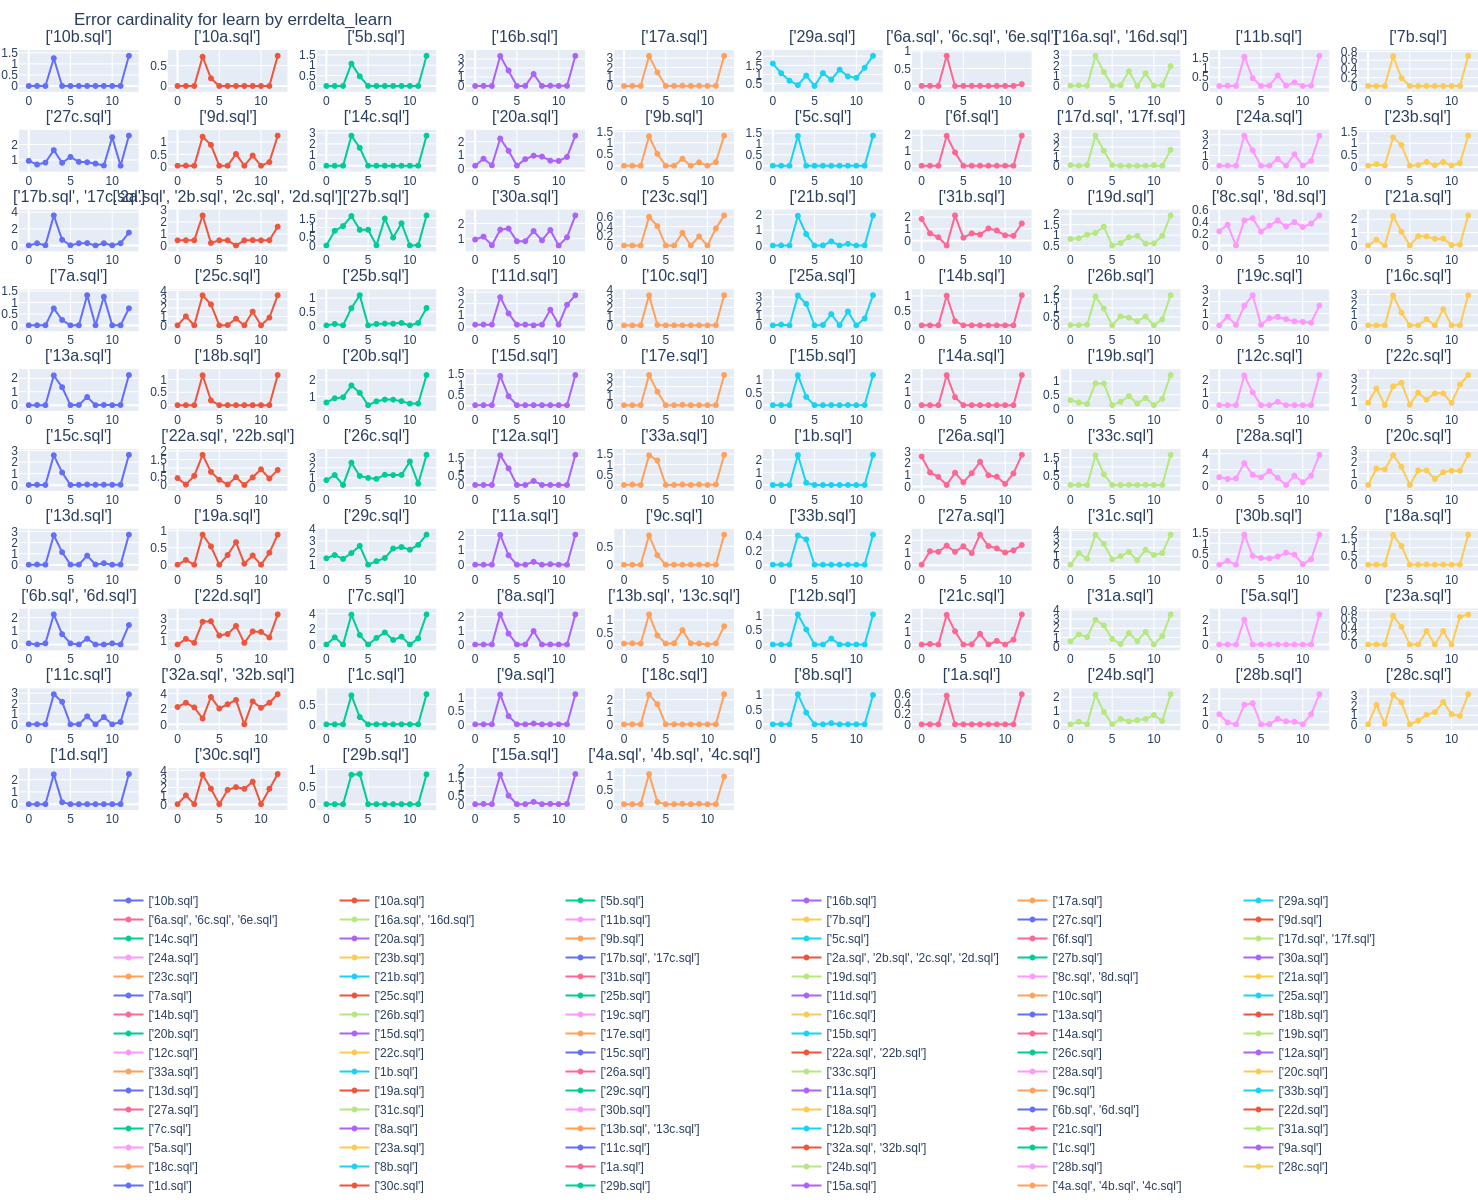

In [174]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_err[learn_df_query_err['query_name']==i]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['errdelta_learn']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                   title_text="Error cardinality for learn by errdelta_learn",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

### query_stats

In [175]:
name_query=list(learn_df_query_stat['query_name'])

In [176]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [177]:
oy=df_temp['cardinality_error_with_aqo_split'].to_list()

In [178]:
ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0])))

In [179]:
ox

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

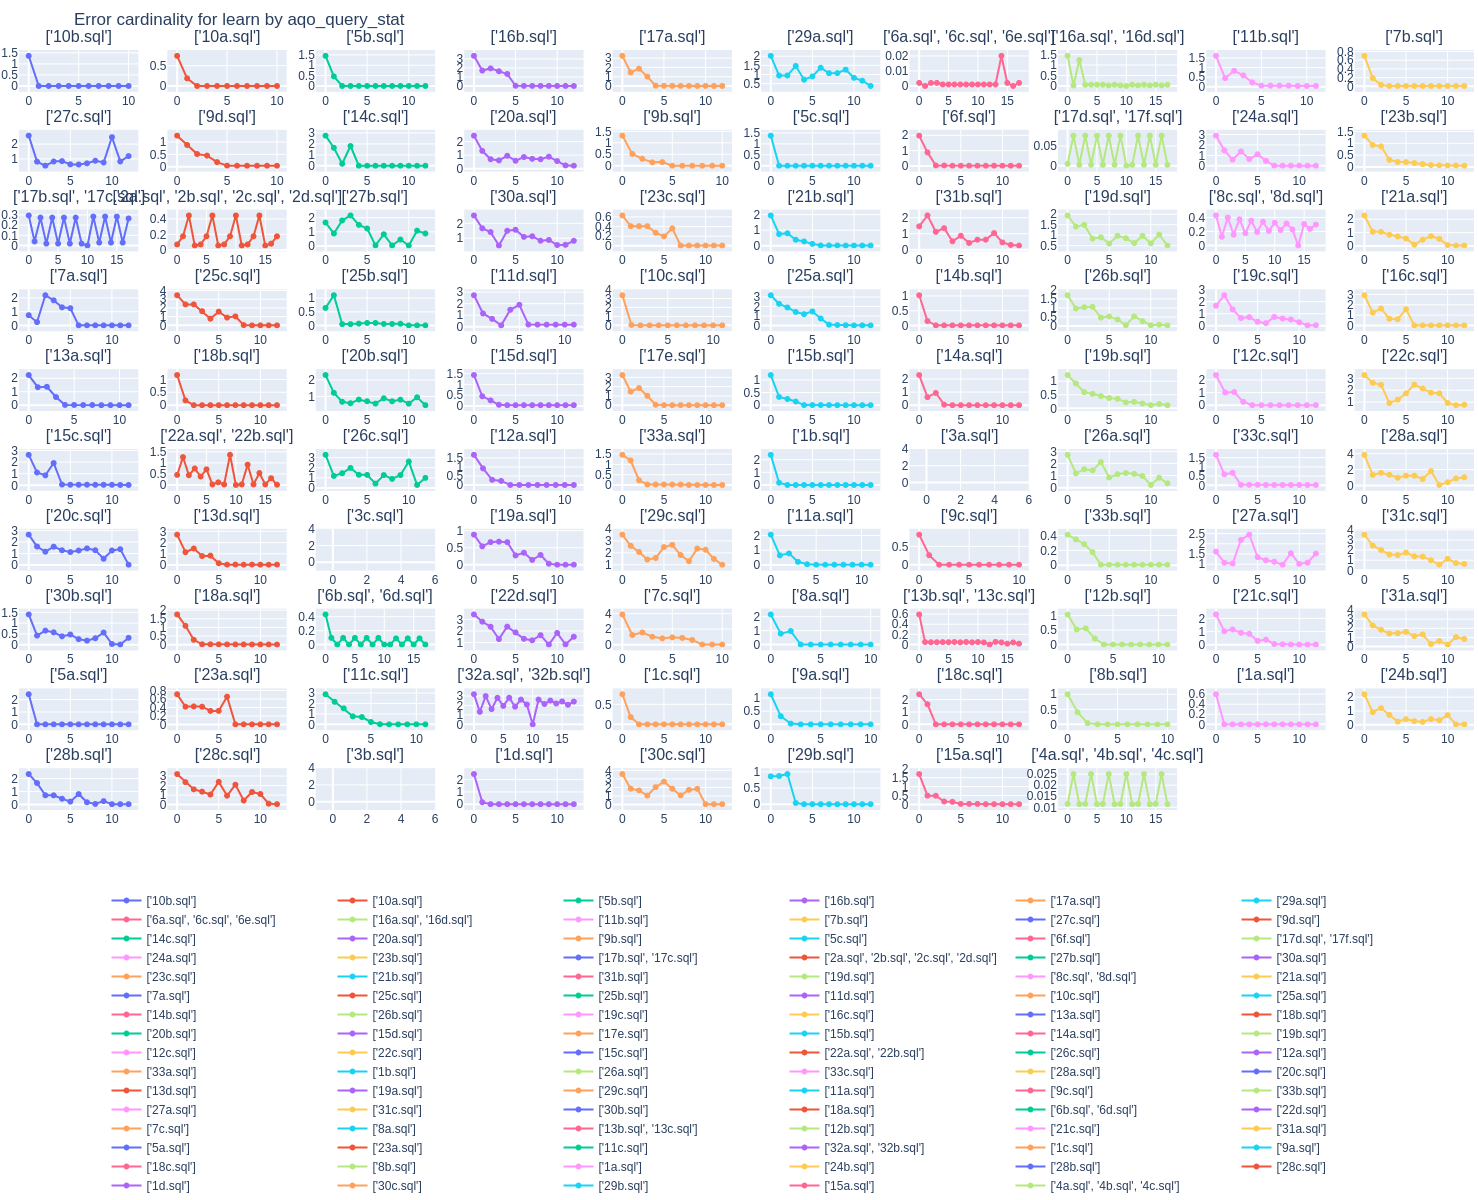

In [180]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text="Error cardinality for learn by aqo_query_stat",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

## execution for every query

### learn_df_ex_pl_time_orig

In [181]:
name_query = list(learn_df_query_err['query_name'].unique())

In [182]:
ox=list(x for x in range(times))

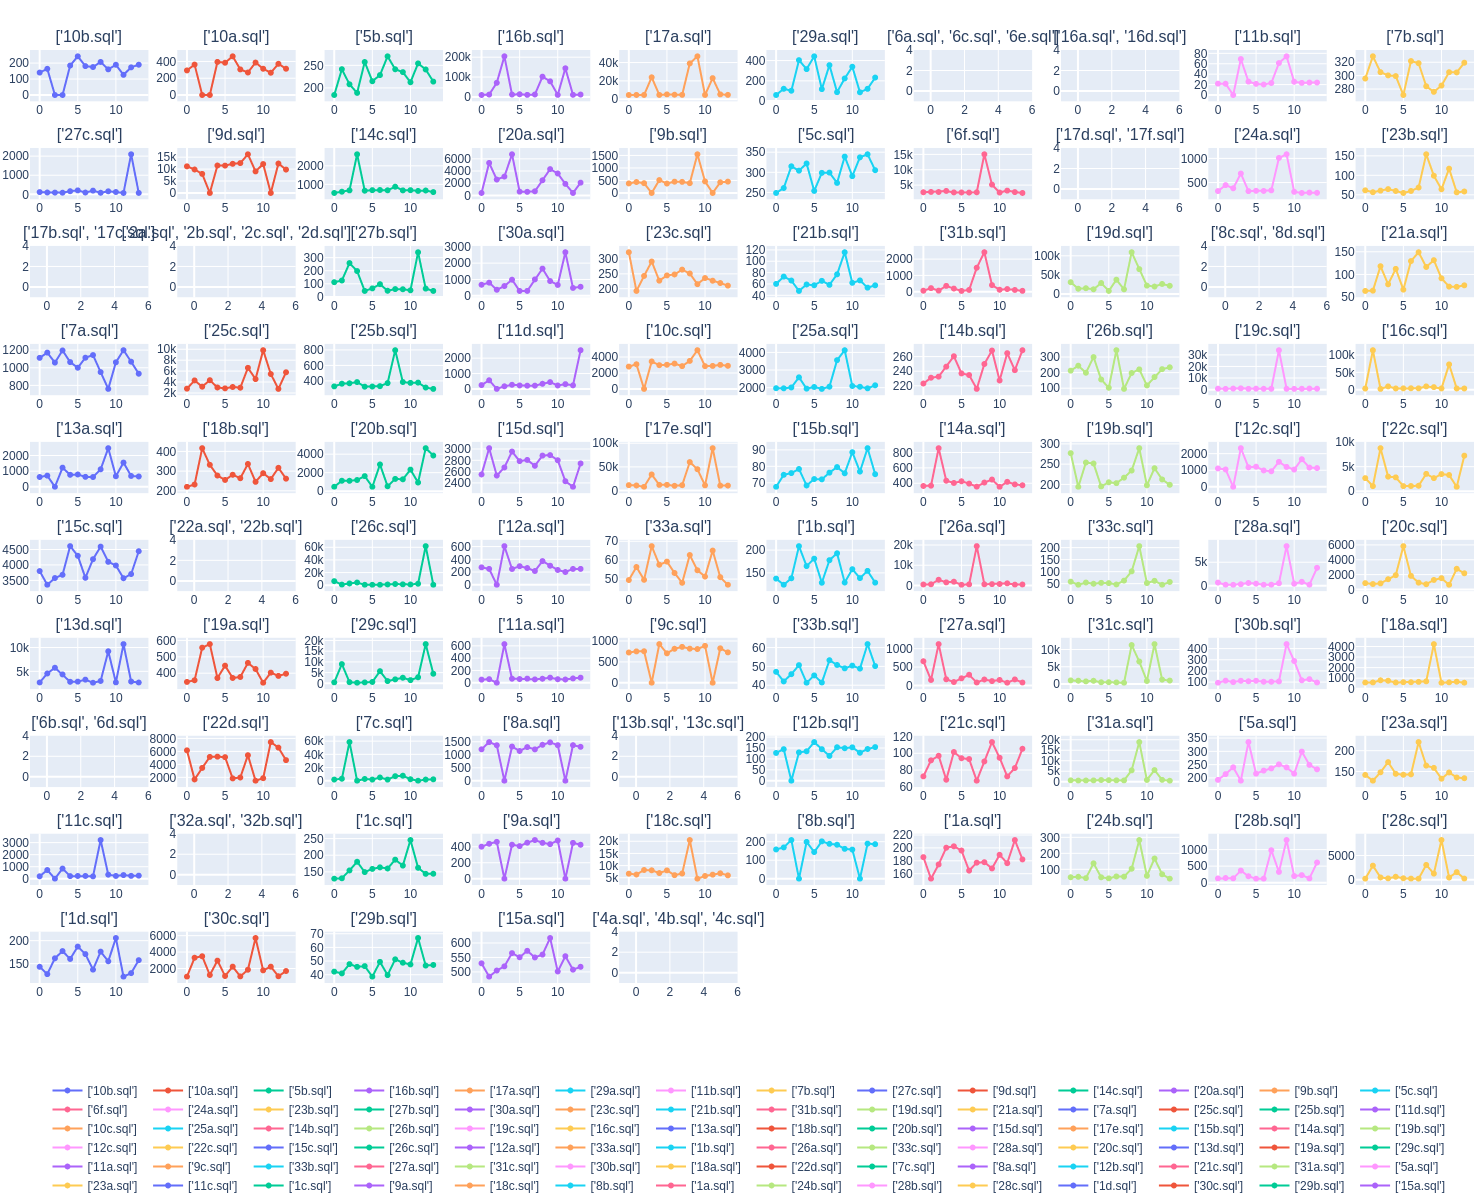

In [183]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

### learn_df_query_stat

In [184]:
name_query=list(learn_df_query_stat['query_name'])

In [185]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [186]:
ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0])))

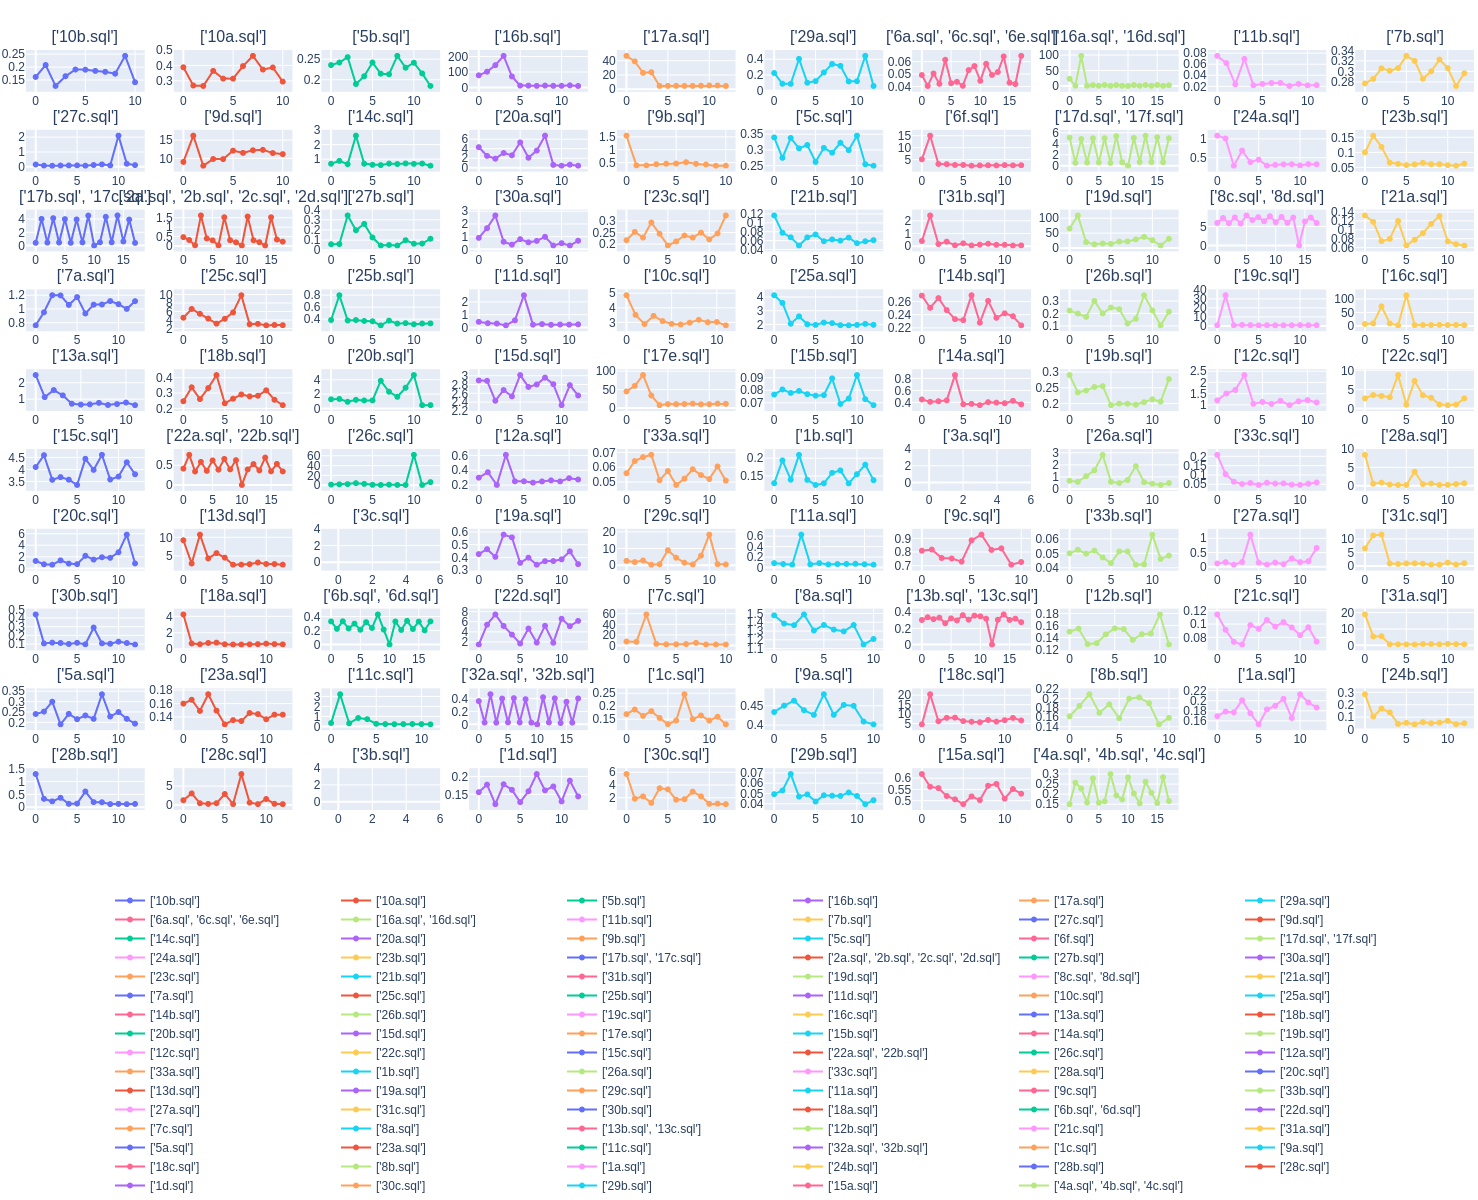

In [187]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

## plan for every query

### learn_df_ex_pl_time_orig

In [188]:
name_query = list(learn_df_query_err['query_name'].unique())

In [189]:
ox=list(x for x in range(times))

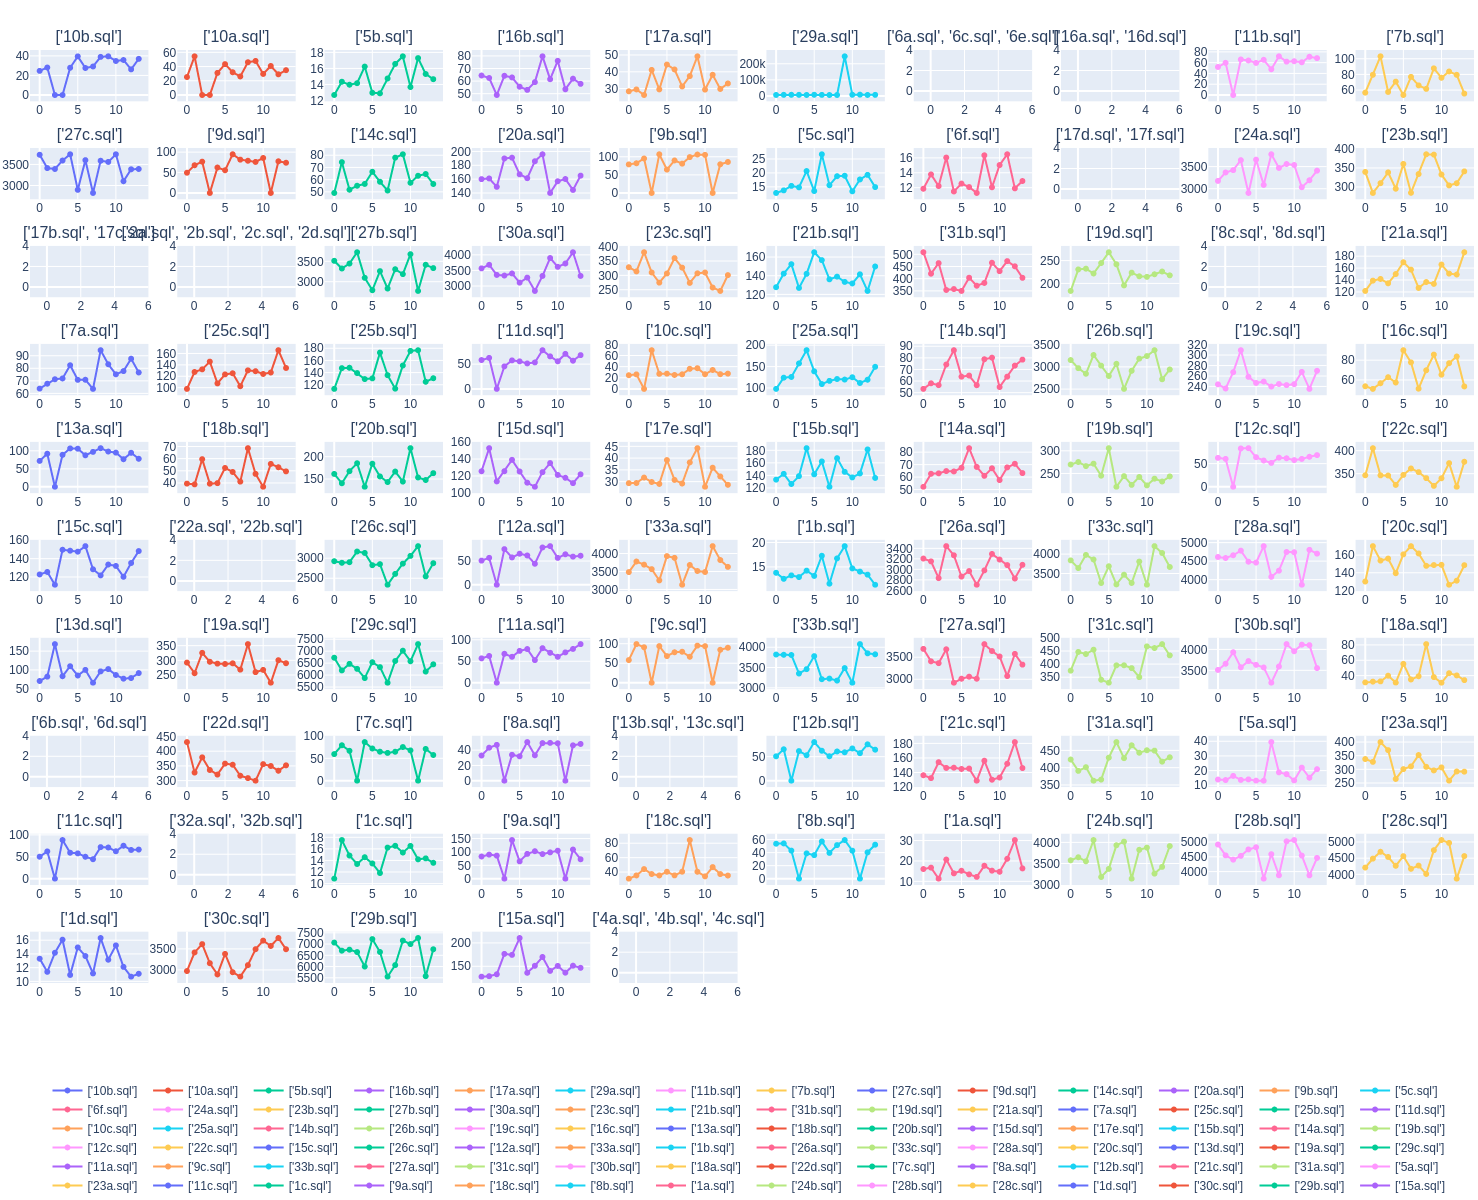

In [190]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['plan_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

### aqo_query_stat

In [191]:
name_query=list(learn_df_query_stat['query_name'])

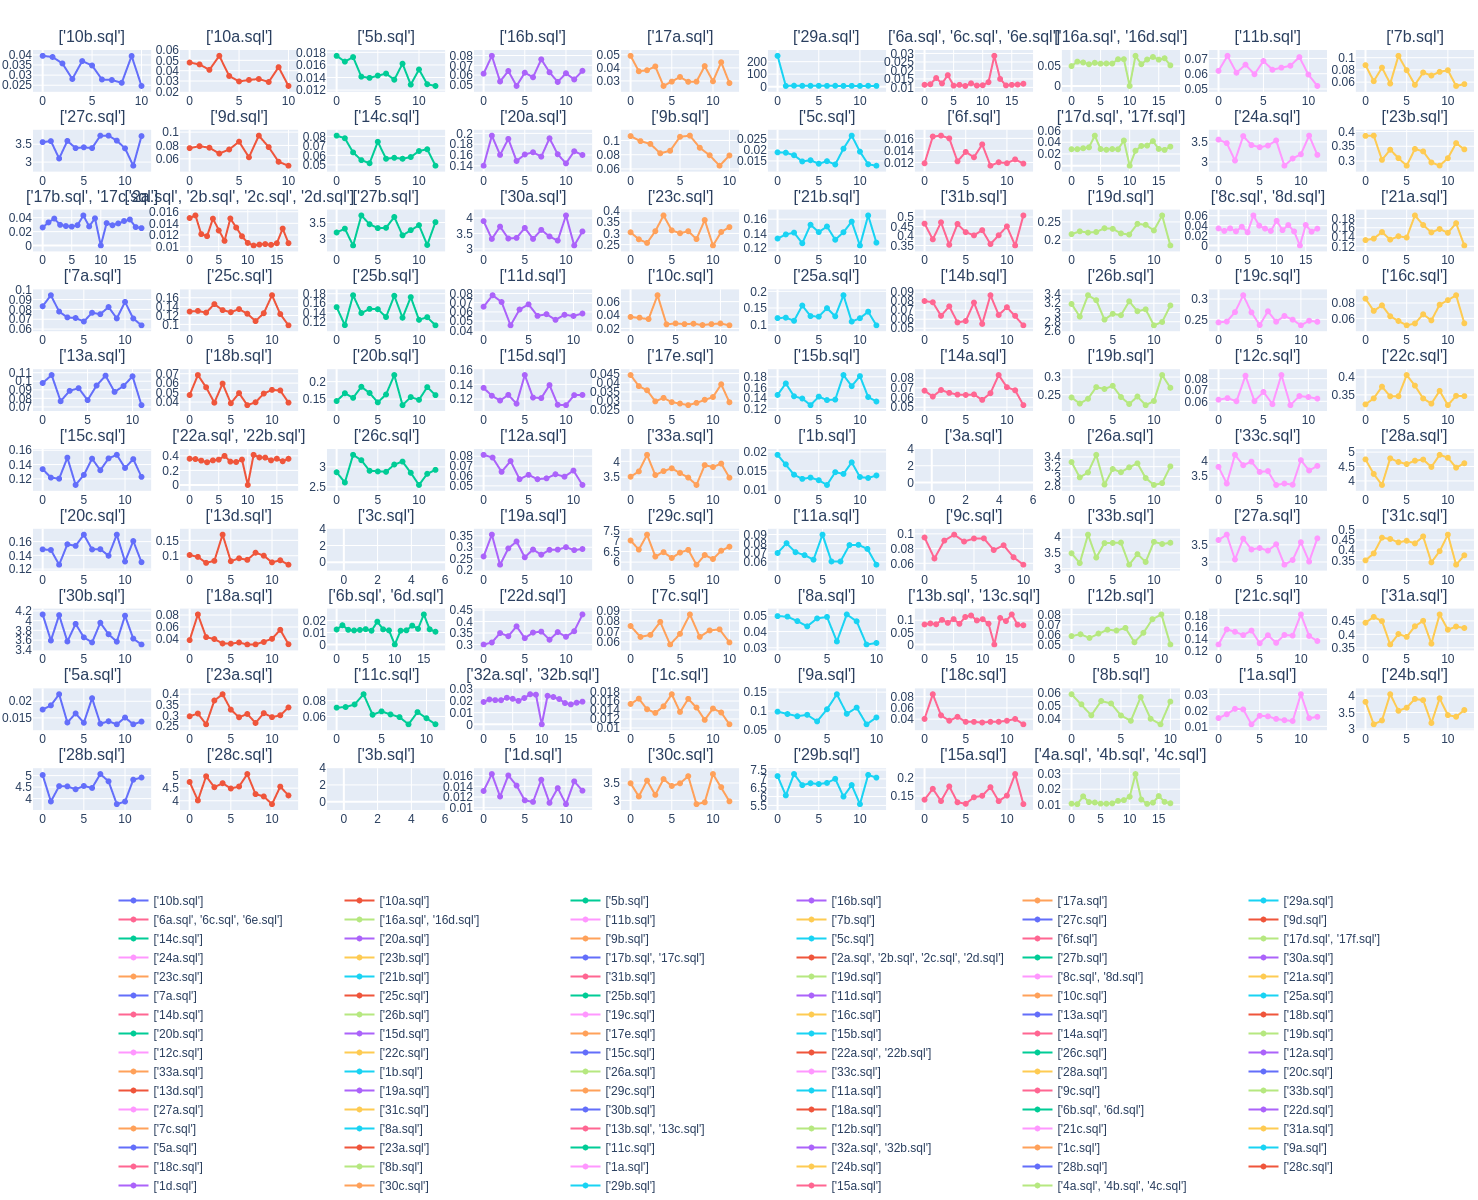

In [192]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['planning_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['planning_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

# build graphs: disabled and control

## query with plan and execution time

### df_ex_pl_time

In [193]:
df_ex_pl_time_copy=df_ex_pl_time.copy()

In [194]:
df_ex_pl_time_copy

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                419.333            47.346   
1               1    10b.sql                190.792            33.281   
2               1    10c.sql               3848.568            30.028   
3               1    11a.sql                 65.882            82.266   
4               1    11b.sql                 17.641            61.466   
..            ...        ...                    ...               ...   
108             1     8d.sql               6379.700            46.157   
109             1     9a.sql                436.036            74.686   
110             1     9b.sql                415.761            77.944   
111             1     9c.sql                792.503            75.925   
112             1     9d.sql              11548.326            89.144   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 2231.772              47.949  
1      988535410010893112                  155.445              18.195  
2     2494719406442254794                 5048.934              15.337  
3    -8754961486292191806                  754.745              38.738  
4     7102013096890644952                   67.948              30.967  
..                    ...                      ...                 ...  
108  -2444720784039749802                 9933.385              28.091  
109  -6747521538659772949                  437.881              41.842  
110    316739818532851506                 1689.392              35.555  
111   -180252288200201541                  835.059              37.695  
112   7221379846823333251                 9223.305              35.106  

[113 rows x 7 columns]

In [195]:
df_ex_pl_time_copy['diff_exec_time']=df_ex_pl_time_copy['execution_time_disabled']-df_ex_pl_time_copy['execution_time_frozen']

In [196]:
df_ex_pl_time_copy['rate_exec_time']=df_ex_pl_time_copy['execution_time_disabled']/df_ex_pl_time_copy['execution_time_frozen']

In [197]:
df_ex_pl_time_copy['diff_plan_time']=df_ex_pl_time_copy['plan_time_disabled']-df_ex_pl_time_copy['plan_time_frozen']

In [198]:
df_ex_pl_time_copy['rate_plan_time']=df_ex_pl_time_copy['plan_time_disabled']/df_ex_pl_time_copy['plan_time_frozen']

In [199]:
exec_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_exec_time']>=2]
plan_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_plan_time']>=2]

In [200]:
exec_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<2) & (df_ex_pl_time_copy['rate_exec_time']>=1)]
plan_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<2) & (df_ex_pl_time_copy['rate_plan_time']>=1)]

In [201]:
exec_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<1) & (df_ex_pl_time_copy['rate_exec_time']>=0)]
plan_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<1) & (df_ex_pl_time_copy['rate_plan_time']>=0)]

In [202]:
exec_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<0)]
plan_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<0)]

In [203]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]
lst_plan=[len(plan_rate_2x), len(plan_rate_1x), len(plan_rate_more_0)]

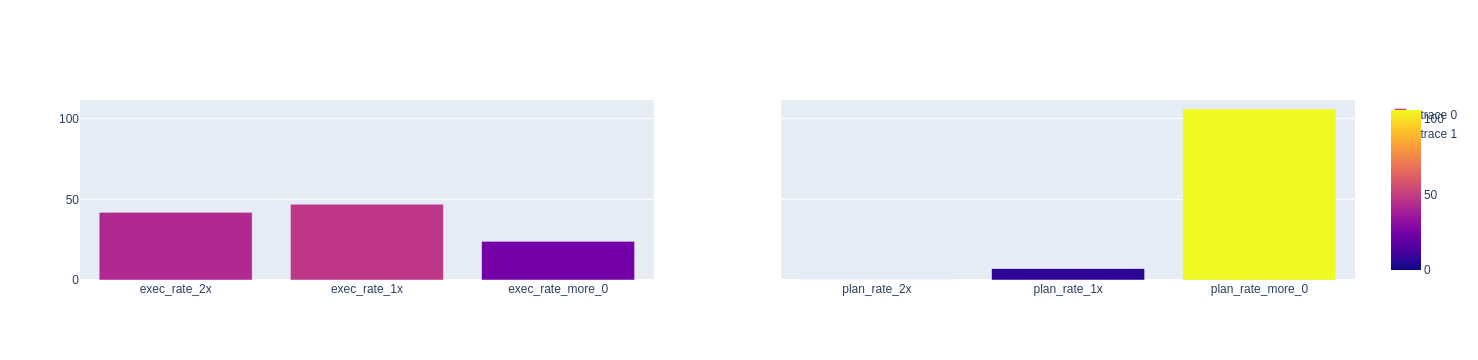

In [204]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=['plan_rate_2x', 'plan_rate_1x', 'plan_rate_more_0'], y=lst_plan,
                    marker=dict(color=lst_plan, coloraxis="coloraxis")),
              1, 2)
fig.show()

In [205]:
df_filter=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']+df_ex_pl_time_copy['rate_plan_time'])>=2]

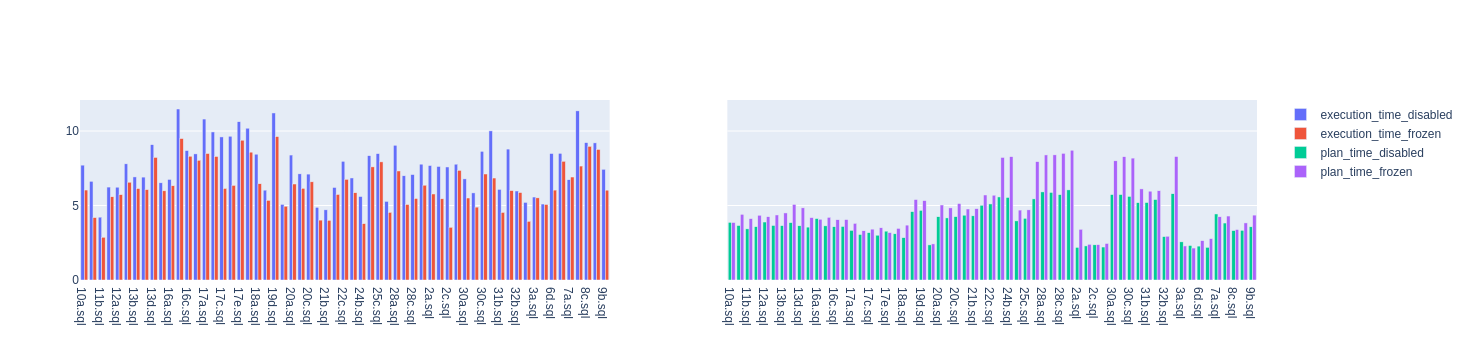

In [206]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=np.log(df_filter['execution_time_disabled'])),
              1, 1)
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['execution_time_frozen'])),
              1, 1)
fig.add_trace(go.Bar(name='plan_time_disabled',x=df_filter['query_name'], y=np.log(df_filter['plan_time_disabled'])),
              1, 2)
fig.add_trace(go.Bar(name='plan_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['plan_time_frozen'])),
              1, 2)
fig.show()

### aqo_query_stat

In [207]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [208]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [209]:
execution_without=[]
for i in frozen_df_query_stat_copy.itertuples(index=False):
    if len(i.execution_time_without_aqo_split)==1:
        execution_without.append(i.execution_time_without_aqo_split[0])
    else:
        execution_without.append(i.execution_time_without_aqo_split[-1])

In [210]:
frozen_df_query_stat_copy['diff_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]-frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [211]:
frozen_df_query_stat_copy['rate_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]/frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [212]:
frozen_df_query_stat_copy['execution_time_without_aqo_split']

0                               [0.156827062]
1                               [2.234047432]
2                               [0.252814765]
3                              [96.557594822]
4                              [49.232758399]
                       ...                   
93                              [0.137679967]
94                              [5.641485233]
95                              [0.033174069]
96                              [0.555299862]
97    [0.258808268, 0.166920745, 0.251412069]
Name: execution_time_without_aqo_split, Length: 98, dtype: object

In [213]:
exec_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_exec_time']>=2]

In [214]:
exec_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<2) & (frozen_df_query_stat_copy['rate_exec_time']>=1)]

In [215]:
exec_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<1) & (frozen_df_query_stat_copy['rate_exec_time']>=0)]

In [216]:
exec_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<0)]

In [217]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]

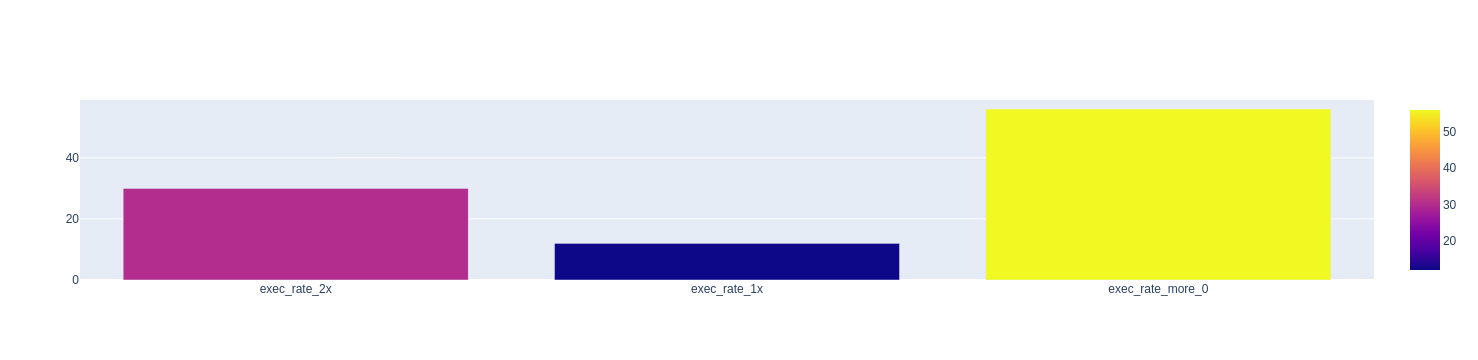

In [218]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [219]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time'])>=2]

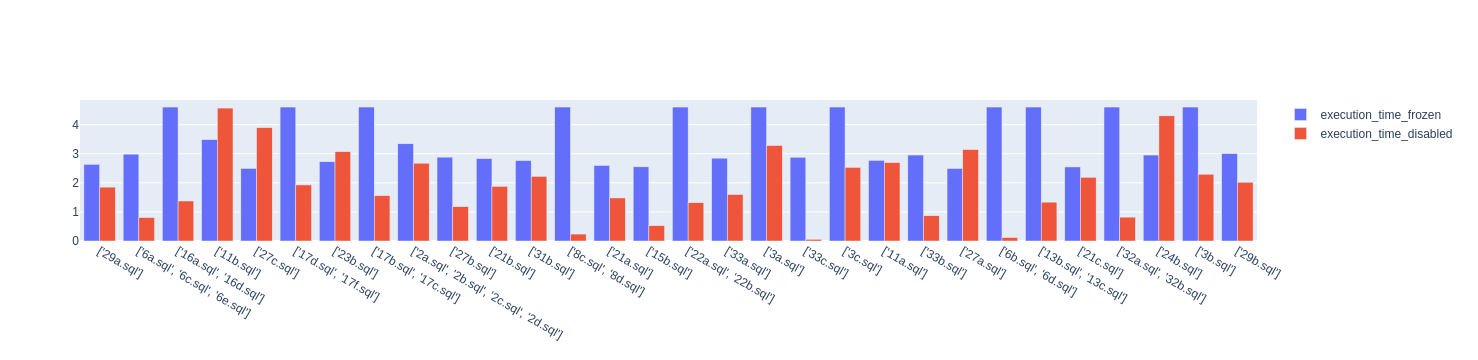

In [221]:
fig = go.Figure()
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=abs(np.log(df_filter['lst_min_exec_with_aqo']+0.01))))
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=abs(np.log(execution_without))))
fig.show()

## query with cardinality error

In [222]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [223]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [224]:
frozen_df_query_stat_copy['diff_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']-frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [225]:
frozen_df_query_stat_copy['rate_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']/frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [226]:
card_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_card_time']>=2]

In [227]:
card_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<2) & (frozen_df_query_stat_copy['rate_card_time']>=1)]

In [228]:
card_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<1) & (frozen_df_query_stat_copy['rate_card_time']>=0)]

In [229]:
card_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<0)]

In [230]:
lst_card=[len(card_rate_2x), len(card_rate_1x), len(card_rate_more_0)]

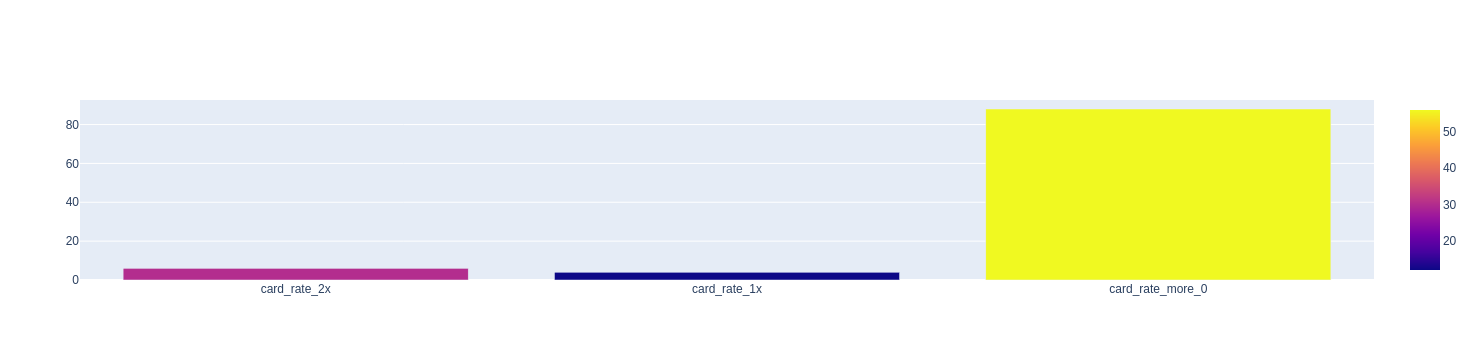

In [231]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_rate_2x', 'card_rate_1x', 'card_rate_more_0'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [232]:
card_less0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<=0.1) & (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0)]
card_eq0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']==0)]
card_more0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0.1) | (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<0)]

In [233]:
lst_card=[len(card_less0_1),len(card_eq0),len(card_more0_1)]

In [234]:
lst_card

[8, 0, 90]

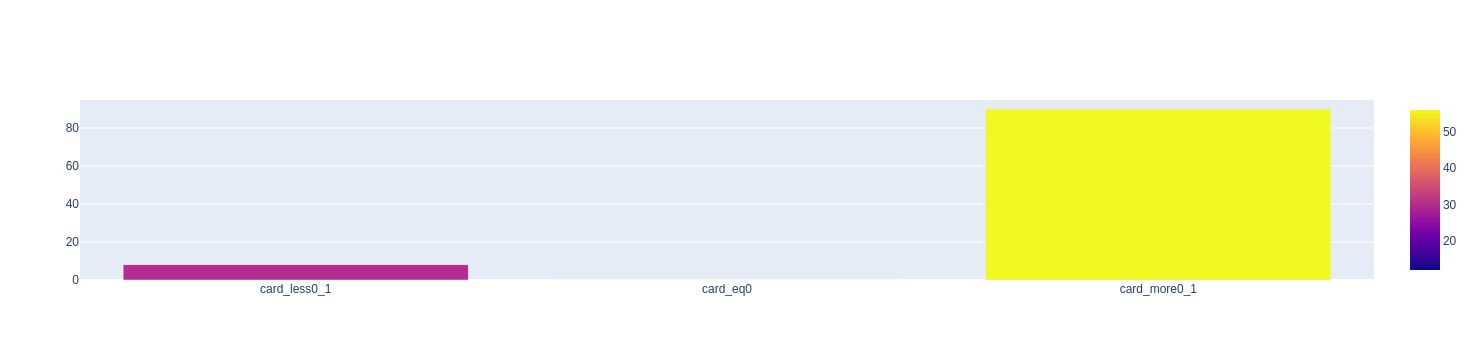

In [235]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_less0_1', 'card_eq0', 'card_more0_1'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [236]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time'])>=2]

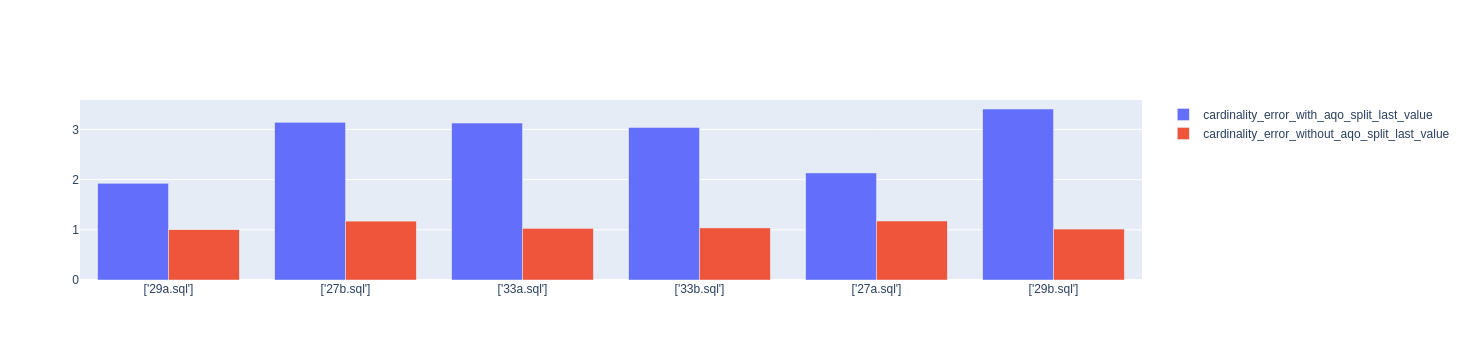

In [237]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error_with_aqo_split_last_value',x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_with_aqo_split_last_value']))))
fig.add_trace(go.Bar(name='cardinality_error_without_aqo_split_last_value', x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_without_aqo_split_last_value']))))
fig.show()

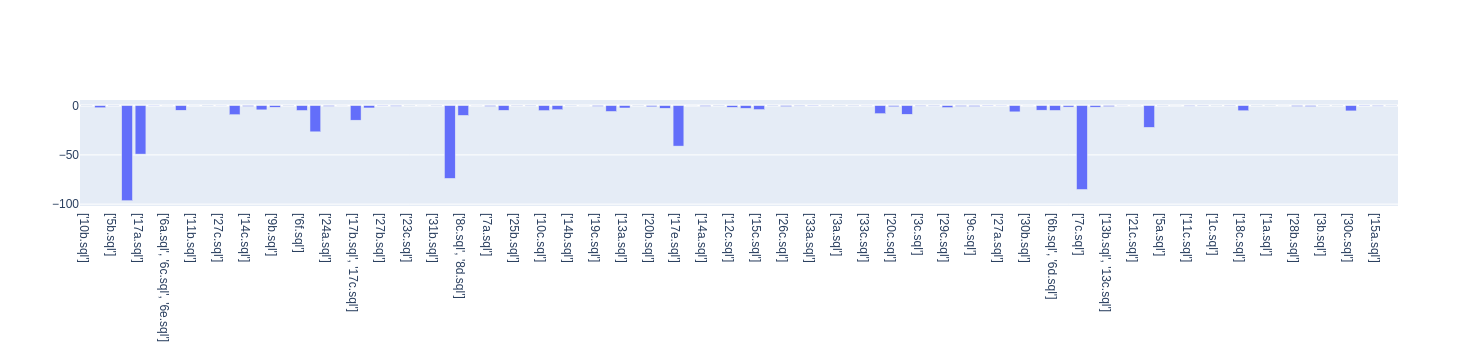

In [238]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error',x=frozen_df_query_stat_copy['query_name'], y=frozen_df_query_stat_copy['diff_card_time']))
fig.show()